# Import packages

In [1]:
import io
import os
import random
import re
import requests
import time
import typing
from typing import Any, Callable, Dict, Type
import warnings

from boruta import BorutaPy
import numpy as np
import optuna
from optuna.visualization import plot_optimization_history, plot_contour, plot_edf, \
    plot_intermediate_values, plot_optimization_history, plot_parallel_coordinate, \
    plot_param_importances, plot_slice
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sb3_contrib.tqc import TQC
from stable_baselines3.a2c import A2C
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import configure
from stable_baselines3.common.monitor import Monitor
import stockstats
import tushare
import yfinance as yf

from environment.MultiStockTradingEnv import MultiStockTradingEnv
from utils.sample_funcs import *
from utils.utils import *

c:\ProgramData\Miniconda3\envs\FTL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\ProgramData\Miniconda3\envs\FTL\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# Config

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

TRAIN_START_DAY = '2008-01-01'
TRAIN_END_DAY = '2016-12-31'
TEST_START_DAY = '2017-01-01'
TEST_END_DAY = '2019-12-31'
TRADE_START_DAY = '2020-01-01'
TRADE_END_DAY = '2022-12-31'

# Setup directories
DATA_SAVE_DIR = 'datasets'
MODEL_DIR = 'models'
TENSORBOARD_LOG_DIR = 'tensorboard_log'
RAW_DATA_DIR = os.path.join(DATA_SAVE_DIR, 'raw')
RAW_DATA_WITHIN_RANGE_DIR = os.path.join(DATA_SAVE_DIR, f'raw_{TRAIN_START_DAY}_{TRADE_END_DAY}')
CLEAN_DATA_DIR = os.path.join(DATA_SAVE_DIR, 'clean')
PREPROCESSED_DATA_DIR = os.path.join(DATA_SAVE_DIR, 'preprocessed')
PREPROCESSED_SSE50_DIR = os.path.join(PREPROCESSED_DATA_DIR, 'SSE50')
PREPROCESSED_HSI_DIR = os.path.join(PREPROCESSED_DATA_DIR, 'HSI')
PREPROCESSED_DJIA_DIR = os.path.join(PREPROCESSED_DATA_DIR, 'DJIA')
PREPROCESSED_DAX30_DIR = os.path.join(PREPROCESSED_DATA_DIR, 'DAX30')


check_and_make_directories([DATA_SAVE_DIR, MODEL_DIR, TENSORBOARD_LOG_DIR, \
     RAW_DATA_DIR, RAW_DATA_WITHIN_RANGE_DIR, CLEAN_DATA_DIR, PREPROCESSED_DATA_DIR, \
     PREPROCESSED_SSE50_DIR, PREPROCESSED_HSI_DIR, PREPROCESSED_DJIA_DIR, PREPROCESSED_DAX30_DIR])


tushare_token = '2bf5fdb105eefda26ef27cc9caa94e6f31ca66e408f7cc54d4fce032'

# Download and prerocess data

## SSE50

### Retrieve SSE 50 component list

In [36]:
# SSE 50 components from http://www.sse.com.cn/market/sseindex/indexlist/basic/index.shtml?COMPANY_CODE=000016&INDEX_Code=000016&type=1
SSE50_COM = \
"""
包钢股份(600010)	中国石化(600028)	中信证券(600030)
三一重工(600031)	招商银行(600036)	保利发展(600048)
上汽集团(600104)	北方稀土(600111)	复星医药(600196)
恒瑞医药(600276)	万华化学(600309)	恒力石化(600346)
国电南瑞(600406)	片仔癀(600436)	    通威股份(600438)
贵州茅台(600519)	海螺水泥(600585)	海尔智家(600690)
闻泰科技(600745)	山西汾酒(600809)	伊利股份(600887)
航发动力(600893)	长江电力(600900)	三峡能源(600905)
隆基绿能(601012)	中信建投(601066)	中国神华(601088)
兴业银行(601166)	陕西煤业(601225)	农业银行(601288)
中国平安(601318)	工商银行(601398)	中国太保(601601)
中国人寿(601628)	长城汽车(601633)	中国建筑(601668)
中国电建(601669)	华泰证券(601688)	中国石油(601857)
中国中免(601888)	紫金矿业(601899)	中远海控(601919)
中金公司(601995)	药明康德(603259)	合盛硅业(603260)
海天味业(603288)	韦尔股份(603501)	华友钴业(603799)
兆易创新(603986)	天合光能(688599)
"""

In [37]:
tic_list = re.findall(r'\d{6}', SSE50_COM)
tic_list = [tic+'.SS' for tic in tic_list]

### Download SSE50 ticker history with yfinace

In [4]:
def download_ticker_with_yfince(tic_list: List[str], download_dir: str) -> List[str]:
    retry_list = []
    for tic in tic_list:
        if tic.startswith('CON'):
            csv_path = os.path.join(download_dir, f'_{tic}.csv')
        else:
            csv_path = os.path.join(download_dir, f'{tic}.csv')
            
        if os.path.exists(csv_path):
            print(f'File {csv_path} already exist. Skip')
            continue
        
        ticker = yf.Ticker(tic)
        df = ticker.history(period='max')
        if df.shape[0] > 0:
            df.to_csv(csv_path)
            print(f'Download {tic}.csv')         
            time.sleep(0.1)
        else:
            retry_list.append(tic)
    
    return retry_list

In [25]:
retry_list = download_ticker_with_yfince(tic_list, RAW_DATA_DIR)

File datasets\raw\600010.SS.csv already exist. Skip
File datasets\raw\600028.SS.csv already exist. Skip
File datasets\raw\600030.SS.csv already exist. Skip
File datasets\raw\600031.SS.csv already exist. Skip
File datasets\raw\600036.SS.csv already exist. Skip
File datasets\raw\600048.SS.csv already exist. Skip
File datasets\raw\600104.SS.csv already exist. Skip
File datasets\raw\600111.SS.csv already exist. Skip
File datasets\raw\600196.SS.csv already exist. Skip
File datasets\raw\600276.SS.csv already exist. Skip
File datasets\raw\600309.SS.csv already exist. Skip
File datasets\raw\600346.SS.csv already exist. Skip
File datasets\raw\600406.SS.csv already exist. Skip
File datasets\raw\600436.SS.csv already exist. Skip
File datasets\raw\600438.SS.csv already exist. Skip
File datasets\raw\600519.SS.csv already exist. Skip
File datasets\raw\600585.SS.csv already exist. Skip
File datasets\raw\600690.SS.csv already exist. Skip
File datasets\raw\600745.SS.csv already exist. Skip
File dataset

In [ ]:
retry_list = download_ticker_with_yfince(retry_list, RAW_DATA_DIR)

### Download data with adjusted price from yfinace within range

In [5]:
def download_ticker_with_yfince_within_range(tic_list, start, end):
    for tic in tic_list:
        if tic.startswith('CON'):
            csv_path = os.path.join(RAW_DATA_DIR, f'_{tic}.csv')
        else:
            csv_path = os.path.join(RAW_DATA_DIR, f'{tic}.csv')

        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path, index_col=False)
            first_day = df['Date'].iloc[0].split(' ')[0]
            last_day = df['Date'].iloc[-1].split(' ')[0]
            if first_day < start and last_day > end:
                if tic.startswith('CON'):
                    csv_path = os.path.join(RAW_DATA_WITHIN_RANGE_DIR, f'_{tic}.csv')
                else:
                    csv_path = os.path.join(RAW_DATA_WITHIN_RANGE_DIR, f'{tic}.csv')
                if not os.path.exists(csv_path):
                    df_within_range = yf.download(tic, start=start, end=end)
                    df_within_range.to_csv(csv_path)
            else:
                print(f'{tic}: from {first_day} to {last_day} out of range.')

In [ ]:
download_ticker_with_yfince_within_range(tic_list, TRAIN_START_DAY, TRADE_END_DAY)

### Preprocess data

In [16]:
NA_THRESHOLD = 0.1
FEATURES = 'kdjj_9 volume change stochrsi ppoh ppo ppos dx_14 cr-ma3 adxr'

def preprocess_data(tic_list, load_dir, save_dir):
    na_list = []
    for tic in tic_list: 
        if tic.startswith('CON'):
            csv_path = os.path.join(load_dir, f'_{tic}.csv')
        else:
            csv_path = os.path.join(load_dir, f'{tic}.csv')

        if not os.path.exists(csv_path):
            print(f'File {csv_path} doesn\'t exist. Skip')
            continue
        data = pd.read_csv(csv_path, index_col=False)

        # rename columns and drop 'close'
        data.drop(labels=['Close'], axis='columns', inplace=True)
        data.rename(columns={
            'Date': 'date',
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Adj Close' : 'close',
            'Volume' : 'volume'
            }, inplace=True)
        data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

        # clean data
        len_df = data.shape[0]
        data.drop_duplicates(subset=['open', 'high', 'low', 'close', 'volume'], inplace=True)
        data.dropna(inplace=True)
        print(f'{len_df - data.shape[0]} rows droped from ticker {tic}.')

        if data.shape[0] < len_df * (1 - NA_THRESHOLD):
            na_list.append(tic)
            print(f'{tic}: too many NaNs, discard.')
            continue

        # add features
        df = pd.DataFrame(index=data['date'])
        data = stockstats.StockDataFrame.retype(data)

        feature_list = FEATURES.split(' ')
        for f in feature_list:
            df[f] = data[f]

        # Drop nan, inf
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        assert df.isna().sum().sum() == 0

        df.reset_index(inplace=True)

        # save data
        if tic.startswith('CON'):
            result_path = os.path.join(save_dir, f'_{tic}.csv')
        else:
            result_path = os.path.join(save_dir, f'{tic}.csv')

        df.to_csv(result_path, index=False)

    return na_list

In [50]:
preprocess_data(tic_list, RAW_DATA_WITHIN_RANGE_DIR, PREPROCESSED_SSE50_DIR)

64 rows droped from ticker 600010.SS.
0 rows droped from ticker 600028.SS.
28 rows droped from ticker 600030.SS.
3 rows droped from ticker 600031.SS.
9 rows droped from ticker 600036.SS.
4 rows droped from ticker 600048.SS.
56 rows droped from ticker 600104.SS.
0 rows droped from ticker 600111.SS.
12 rows droped from ticker 600196.SS.
3 rows droped from ticker 600276.SS.
129 rows droped from ticker 600309.SS.
301 rows droped from ticker 600346.SS.
140 rows droped from ticker 600406.SS.
9 rows droped from ticker 600436.SS.
140 rows droped from ticker 600438.SS.
0 rows droped from ticker 600519.SS.
7 rows droped from ticker 600585.SS.
84 rows droped from ticker 600690.SS.
477 rows droped from ticker 600745.SS.
600745.SS: too many NaNs, discard.
12 rows droped from ticker 600809.SS.
28 rows droped from ticker 600887.SS.
124 rows droped from ticker 600893.SS.
161 rows droped from ticker 600900.SS.
File datasets\raw_2008-01-01_2022-12-31\600905.SS.csv doesn't exist. Skip
35 rows droped from

['600745.SS', '603501.SS', '603986.SS']

## HSI

In [65]:
# Copy from https://www.hsi.com.hk/chi/indexes/all-indexes/hsi
HSI_components = '''
5	滙豐控股	+6
11	恒生銀行	0
388	香港交易所	+12
939	建設銀行	-2
1299	友邦保險	+41
1398	工商銀行	-4
2318	中國平安	+16
2388	中銀香港	0
2628	中國人壽	+6
3968	招商銀行	0
3988	中國銀行	+1
2	中電控股	0
3	香港中華煤氣	0
6	電能實業	0
1038	長江基建集團	0
2688	新奧能源	0
12	恒基地產	0
16	新鴻基地產	-1
17	新世界發展	+1
101	恒隆地產	0
688	中國海外發展	0
823	領展房產基金	-2
960	龍湖集團	+2
1109	華潤置地	+1
1113	長實集團	0
1209	華潤萬象生活	+1
1997	九龍倉置業	0
2007	碧桂園	+1
6098	碧桂園服務	+1
1	長和	+2
27	銀河娛樂	+6
66	港鐵公司	0
175	吉利汽車	+3
241	阿里健康	+2
267	中信股份	-1
288	萬洲國際	0
291	華潤啤酒	+5
316	東方海外國際	0
322	康師傅控股	0
386	中國石油化工股份	0
669	創科實業	+2
700	騰訊控股	+69
762	中國聯通	+1
857	中國石油股份	0
868	信義玻璃	+1
881	中升控股	+1
883	中國海洋石油	-3
941	中國移動	+4
968	信義光能	+2
981	中芯國際	+4
992	聯想集團	+2
1044	恒安國際	0
1088	中國神華	0
1093	石藥集團	0
1177	中國生物製藥	+1
1211	比亞迪股份	+11
1378	中國宏橋	0
1810	小米集團 - W	+30
1876	百威亞太	+1
1928	金沙中國有限公司	+7
1929	周大福	0
2020	安踏體育	+4
2269	藥明生物	+3
2313	申洲國際	+1
2319	蒙牛乳業	0
2331	李寧	+7
2382	舜宇光學科技	+7
3690	美團 - W	+3
3692	翰森製藥	+1
6690	海爾智家	+2
6862	海底撈	+2
9618	京東集團 - SW	+15
9633	農夫山泉	-2
9888	百度集團 - SW	-6
9988	阿里巴巴 - SW	+72
9999	網易 - S	+1
'''

In [69]:
tic_list = [tic_row.split('\t')[0] for tic_row in HSI_components.strip().split('\n')]
tic_list = [f'{int(tic):04d}.HK' for tic in tic_list]

In [71]:
retry_list = download_ticker_with_yfince(tic_list, RAW_DATA_DIR)

Download 0005.HK.csv
Download 0011.HK.csv
Download 0388.HK.csv
Download 0939.HK.csv
Download 1299.HK.csv
Download 1398.HK.csv
Download 2318.HK.csv
Download 2388.HK.csv
2628.HK: No data found for this date range, symbol may be delisted
Download 3968.HK.csv
Download 3988.HK.csv
Download 0002.HK.csv
Download 0003.HK.csv
Download 0006.HK.csv
Download 1038.HK.csv
Download 2688.HK.csv
Download 0012.HK.csv
Download 0016.HK.csv
Download 0017.HK.csv
Download 0101.HK.csv
Download 0688.HK.csv
Download 0823.HK.csv
Download 0960.HK.csv
Download 1109.HK.csv
Download 1113.HK.csv
Download 1209.HK.csv
Download 1997.HK.csv
Download 2007.HK.csv
Download 6098.HK.csv
Download 0001.HK.csv
Download 0027.HK.csv
Download 0066.HK.csv
Download 0175.HK.csv
Download 0241.HK.csv
Download 0267.HK.csv
Download 0288.HK.csv
Download 0291.HK.csv
Download 0316.HK.csv
Download 0322.HK.csv
Download 0386.HK.csv
Download 0669.HK.csv
Download 0700.HK.csv
Download 0762.HK.csv
Download 0857.HK.csv
Download 0868.HK.csv
Download 

In [72]:
retry_list = download_ticker_with_yfince(retry_list, RAW_DATA_DIR)

Download 2628.HK.csv
Download 0981.HK.csv


In [75]:
download_ticker_with_yfince_within_range(tic_list, TRAIN_START_DAY, TRADE_END_DAY)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
1299.HK: from 2010-10-29 to 2023-02-09 out of range.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]

In [76]:
preprocess_data(tic_list, RAW_DATA_WITHIN_RANGE_DIR, PREPROCESSED_HSI_DIR)

0 rows droped from ticker 0005.HK.
0 rows droped from ticker 0011.HK.
0 rows droped from ticker 0388.HK.
0 rows droped from ticker 0939.HK.
File datasets\raw_2008-01-01_2022-12-31\1299.HK.csv doesn't exist. Skip
0 rows droped from ticker 1398.HK.
4 rows droped from ticker 2318.HK.
0 rows droped from ticker 2388.HK.
0 rows droped from ticker 2628.HK.
3 rows droped from ticker 3968.HK.
0 rows droped from ticker 3988.HK.
0 rows droped from ticker 0002.HK.
1 rows droped from ticker 0003.HK.
0 rows droped from ticker 0006.HK.
0 rows droped from ticker 1038.HK.
4 rows droped from ticker 2688.HK.
0 rows droped from ticker 0012.HK.
1 rows droped from ticker 0016.HK.
3 rows droped from ticker 0017.HK.
0 rows droped from ticker 0101.HK.
0 rows droped from ticker 0688.HK.
0 rows droped from ticker 0823.HK.
File datasets\raw_2008-01-01_2022-12-31\0960.HK.csv doesn't exist. Skip
1 rows droped from ticker 1109.HK.
File datasets\raw_2008-01-01_2022-12-31\1113.HK.csv doesn't exist. Skip
File datasets\

[]

## DJI

In [81]:
# copy from https://www.slickcharts.com/dowjones
DJI_components = '''
#	Company	Symbol	Weight	      Price	Chg	% Chg
1	UnitedHealth Group Incorporated	UNH	9.201192	   485.70	8.82	(1.85%)
2	Goldman Sachs Group Inc.	GS	7.223885	   376.46	2.06	(0.55%)
3	Home Depot Inc.	HD	6.274593	   320.79	-4.41	(-1.36%)
4	Microsoft Corporation	MSFT	5.162454	   270.42	2.86	(1.07%)
5	McDonald's Corporation	MCD	5.158209	   263.52	-3.82	(-1.43%)
6	Caterpillar Inc.	CAT	4.817081	   248.87	-0.79	(-0.32%)
7	Amgen Inc.	AMGN	4.707874	   243.00	-1.00	(-0.41%)
8	Visa Inc. Class A	V	4.463219	   231.20	-0.12	(-0.05%)
9	Boeing Company	BA	4.143701	   214.62	-0.14	(-0.07%)
10	Honeywell International Inc.	HON	3.964454	   203.17	-2.30	(-1.12%)
11	Travelers Companies Inc.	TRV	3.646865	   187.39	-1.62	(-0.86%)
12	American Express Company	AXP	3.447939	   179.22	0.52	(0.29%)
13	Chevron Corporation	CVX	3.358991	   170.21	-3.88	(-2.23%)
14	Salesforce Inc.	CRM	3.304773	   172.44	1.16	(0.68%)
15	Johnson & Johnson	JNJ	3.152732	   164.14	0.74	(0.45%)
16	Apple Inc.	AAPL	2.983904	   153.20	-1.45	(-0.94%)
17	JPMorgan Chase & Co.	JPM	2.771664	   143.03	-0.62	(-0.43%)
18	Walmart Inc.	WMT	2.720148	   139.28	-1.70	(-1.21%)
19	Procter & Gamble Company	PG	2.701625	   139.12	-0.90	(-0.64%)
20	International Business Machines Corporation	IBM	2.620974	   134.88	-0.96	(-0.71%)
21	NIKE Inc. Class B	NKE	2.418188	   123.76	-1.57	(-1.25%)
22	3M Company	MMM	2.255535	   116.00	-0.90	(-0.77%)
23	Walt Disney Company	DIS	2.153852	   118.55	6.92	(6.20%)
24	Merck & Co. Inc.	MRK	2.03905	   107.00	1.32	(1.25%)
25	Dow Inc.	DOW	1.167514	   59.81	-0.70	(-1.16%)
26	Coca-Cola Company	KO	1.159024	   59.92	-0.15	(-0.25%)
27	Cisco Systems Inc.	CSCO	0.923052	   47.25	-0.59	(-1.23%)
28	Verizon Communications Inc.	VZ	0.782395	   40.60	0.05	(0.12%)
29	Walgreens Boots Alliance Inc.	WBA	0.708882	   36.74	0.00	(0.00%)
30	Intel Corporation	INTC	0.560507	   28.47	-0.58	(-2.00%)
'''

In [86]:
df = pd.read_csv(io.StringIO(DJI_components), sep='\t')
tic_list = df.Symbol.to_list()

In [87]:
retry_list = download_ticker_with_yfince(tic_list, RAW_DATA_DIR)

Download UNH.csv
Download GS.csv
Download HD.csv
Download MSFT.csv
Download MCD.csv
Download CAT.csv
Download AMGN.csv
Download V.csv
Download BA.csv
Download HON.csv
Download TRV.csv
Download AXP.csv
Download CVX.csv
Download CRM.csv
Download JNJ.csv
Download AAPL.csv
Download JPM.csv
Download WMT.csv
Download PG.csv
Download IBM.csv
Download NKE.csv
Download MMM.csv
Download DIS.csv
Download MRK.csv
Download DOW.csv
Download KO.csv
Download CSCO.csv
Download VZ.csv
Download WBA.csv
Download INTC.csv


In [ ]:
retry_list = download_ticker_with_yfince(retry_list, RAW_DATA_DIR)

In [88]:
download_ticker_with_yfince_within_range(tic_list, TRAIN_START_DAY, TRADE_END_DAY)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
V: from 2008-03-19 to 2023-02-08 out of range.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of

In [ ]:
preprocess_data(tic_list, RAW_DATA_WITHIN_RANGE_DIR, PREPROCESSED_DJIA_DIR)

## DAX30

In [8]:
# Copy from 
DAX30_component = '''
Symbol	Company Name	Last Price	Change	% Change	Volume
HNR1.DE	Hannover Rück SE	181.75	0.00	0.00%	21,182
1COV.DE	Covestro AG	42.57	0.05	+0.12%	160,831
AIR.DE	Airbus SE	113.60	0.30	+0.26%	68,162
BAS.DE	BASF SE	53.00	0.14	+0.26%	406,746
RWE.DE	RWE Aktiengesellschaft	40.49	-0.12	-0.30%	197,185
BAYN.DE	Bayer Aktiengesellschaft	62.27	-0.22	-0.35%	3,027,871
FME.DE	Fresenius Medical Care AG & Co. KGaA	36.68	-0.13	-0.35%	88,328
SY1.DE	Symrise AG	99.04	-0.44	-0.44%	71,780
ZAL.DE	Zalando SE	42.32	0.19	+0.45%	158,081
DTE.DE	Deutsche Telekom AG	20.26	0.11	+0.55%	1,418,280
FRE.DE	Fresenius SE & Co. KGaA	27.64	-0.18	-0.65%	252,857
LIN.DE	Linde plc	313.50	-2.10	-0.67%	124,968
BEI.DE	Beiersdorf Aktiengesellschaft	110.55	0.75	+0.68%	35,654
CON.DE	Continental Aktiengesellschaft	71.16	0.50	+0.71%	44,916
MTX.DE	MTU Aero Engines AG	227.00	1.60	+0.71%	15,685
ADS.DE	adidas AG	155.26	1.26	+0.82%	65,209
MRK.DE	MERCK Kommanditgesellschaft auf Aktien	186.55	1.55	+0.84%	96,058
SHL.DE	Siemens Healthineers AG	53.56	-0.48	-0.89%	66,525
DBK.DE	Deutsche Bank Aktiengesellschaft	11.78	0.11	+0.96%	2,280,258
VOW3.DE	Volkswagen AG	130.66	1.36	+1.05%	145,762
HEI.DE	HeidelbergCement AG	62.56	0.68	+1.10%	63,760
P911.DE	Dr. Ing. h.c. F. Porsche AG	115.10	1.30	+1.14%	80,614
BMW.DE	Bayerische Motoren Werke Aktiengesellschaft	98.70	1.13	+1.16%	159,290
ALV.DE	Allianz SE	223.35	2.60	+1.18%	474,631
DPW.DE	Deutsche Post AG	41.92	0.51	+1.24%	453,072
DTG.DE	Daimler Truck Holding AG	31.83	0.52	+1.64%	327,260
IFX.DE	Infineon Technologies AG	36.10	0.59	+1.66%	450,803
ENR.DE	Siemens Energy AG	18.92	0.46	+2.46%	452,242
DB1.DE	Deutsche Börse AG	171.50	5.20	+3.13%	127,123
SIE.DE	Siemens Aktiengesellschaft	151.40	11.34	+8.10%	1,537,042
'''

In [13]:
df = pd.read_csv(io.StringIO(DAX30_component), sep='\t')
tic_list = df.Symbol.to_list()

In [15]:
retry_list = download_ticker_with_yfince(tic_list, RAW_DATA_DIR)

File datasets\raw\HNR1.DE.csv already exist. Skip
File datasets\raw\1COV.DE.csv already exist. Skip
File datasets\raw\AIR.DE.csv already exist. Skip
File datasets\raw\BAS.DE.csv already exist. Skip
File datasets\raw\RWE.DE.csv already exist. Skip
File datasets\raw\BAYN.DE.csv already exist. Skip
File datasets\raw\FME.DE.csv already exist. Skip
File datasets\raw\SY1.DE.csv already exist. Skip
File datasets\raw\ZAL.DE.csv already exist. Skip
File datasets\raw\DTE.DE.csv already exist. Skip
File datasets\raw\FRE.DE.csv already exist. Skip
File datasets\raw\LIN.DE.csv already exist. Skip
File datasets\raw\BEI.DE.csv already exist. Skip
File datasets\raw\_CON.DE.csv already exist. Skip
File datasets\raw\MTX.DE.csv already exist. Skip
File datasets\raw\ADS.DE.csv already exist. Skip
File datasets\raw\MRK.DE.csv already exist. Skip
File datasets\raw\SHL.DE.csv already exist. Skip
File datasets\raw\DBK.DE.csv already exist. Skip
File datasets\raw\VOW3.DE.csv already exist. Skip
File datasets\r

In [ ]:
retry_list = download_ticker_with_yfince(retry_list, RAW_DATA_DIR)

In [11]:
download_ticker_with_yfince_within_range(tic_list, TRAIN_START_DAY, TRADE_END_DAY)

1COV.DE: from 2015-10-06 to 2023-02-09 out of range.
ZAL.DE: from 2014-10-01 to 2023-02-09 out of range.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
SHL.DE: from 2018-04-12 to 2023-02-09 out of range.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
P911.DE: from 2022-09-30 to 2023-02-09 out of range.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
DTG.DE: from 2021-12-10 to 2023-02-09 out of range.
[*********************100%**********************

In [17]:
preprocess_data(tic_list, RAW_DATA_WITHIN_RANGE_DIR, PREPROCESSED_DAX30_DIR)

5 rows droped from ticker HNR1.DE.
File datasets\raw_2008-01-01_2022-12-31\1COV.DE.csv doesn't exist. Skip
5 rows droped from ticker AIR.DE.
1 rows droped from ticker BAS.DE.
3 rows droped from ticker RWE.DE.
40 rows droped from ticker BAYN.DE.
1 rows droped from ticker FME.DE.
3 rows droped from ticker SY1.DE.
File datasets\raw_2008-01-01_2022-12-31\ZAL.DE.csv doesn't exist. Skip
3 rows droped from ticker DTE.DE.
5 rows droped from ticker FRE.DE.
2493 rows droped from ticker LIN.DE.
LIN.DE: too many NaNs, discard.
5 rows droped from ticker BEI.DE.
3 rows droped from ticker CON.DE.
4 rows droped from ticker MTX.DE.
3 rows droped from ticker ADS.DE.
5 rows droped from ticker MRK.DE.
File datasets\raw_2008-01-01_2022-12-31\SHL.DE.csv doesn't exist. Skip
3 rows droped from ticker DBK.DE.
1 rows droped from ticker VOW3.DE.
5 rows droped from ticker HEI.DE.
File datasets\raw_2008-01-01_2022-12-31\P911.DE.csv doesn't exist. Skip
3 rows droped from ticker BMW.DE.
1 rows droped from ticker ALV

['LIN.DE']

## Download index history

### SSE50

In [19]:
# download SSE50, CSI300 from https://www.csindex.com.cn/#/indices/family/list

### HSI

In [20]:
df = yf.download('^HSI', start=TRAIN_START_DAY, end=TRADE_END_DAY)
df.to_csv(f'./datasets/HSI_{TRAIN_START_DAY}-{TRADE_END_DAY}', index=False)

[*********************100%***********************]  1 of 1 completed


### DJI

In [21]:
df = yf.download('^DJI', start=TRAIN_START_DAY, end=TRADE_END_DAY)
df.to_csv(f'./datasets/DJI_{TRAIN_START_DAY}-{TRADE_END_DAY}', index=False)

[*********************100%***********************]  1 of 1 completed


### DAX30

In [23]:
df = yf.download('^GDAXI', start=TRAIN_START_DAY, end=TRADE_END_DAY)
df.to_csv(f'./datasets/DAX30_{TRAIN_START_DAY}-{TRADE_END_DAY}', index=False)

[*********************100%***********************]  1 of 1 completed


# Setup environment

In [3]:
dataset_dir = os.path.join(PREPROCESSED_DATA_DIR, 'SSE50')
# load data

df_dict = {}
_, _, files = next(os.walk(dataset_dir))
for file in files:
    processed_file_path = os.path.join(dataset_dir, file)   
    df = pd.read_csv(processed_file_path, index_col=False)
    tic = file.replace('.csv', '')
    df_dict[tic] = df.copy()

In [4]:
# Split data
df_dict_train = dict()
df_dict_test = dict()
df_dict_trade = dict()

TEST_START_DAY = pd.to_datetime(TEST_START_DAY, format='%Y-%m-%d')
TRADE_START_DAY = pd.to_datetime(TRADE_START_DAY, format='%Y-%m-%d')

for tic, df in df_dict.items():
    df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
    df_dict_train[tic] = df.loc[df.date < TEST_START_DAY].sort_index(ascending=True).copy()
    df_dict_test[tic] = df.loc[(df.date >= TEST_START_DAY) & (df.date < TRADE_START_DAY)].sort_index(ascending=True).copy()
    df_dict_trade[tic] = df.loc[df.date >= TRADE_START_DAY].sort_index(ascending=True).copy()

In [5]:
def get_envs(n_tickers: int = 10) -> Tuple[MultiStockTradingEnv, MultiStockTradingEnv, MultiStockTradingEnv]:
    assert n_tickers <= len(df_dict_train)

    env_list = list()
    tic_list = random.sample(df_dict_train.keys(), n_tickers)
    for _df_dict in [df_dict_train, df_dict_test, df_dict_trade]:
        _dfs = list()
        for tic in tic_list:
            _df = _df_dict[tic]
            _df['tic'] = tic
            _dfs.append(_df)
        _dfs = pd.concat(_dfs)
        # drop dates that missing data
        _dfs = _dfs.pivot_table(df, index=['date'], columns=['tic']).dropna().stack().reset_index()
        _dfs.sort_values(['date', 'tic'], inplace=True)
        _dfs.set_index(['date', 'tic'], inplace=True)
        env_list.append(Monitor(MultiStockTradingEnv(_dfs)))
    
    return tuple(env_list)

# Hyper parameter tuning

In [6]:
VERBOSE = 0

In [7]:
def objective_factory(
    model_name: str, 
    model_class: Type[BaseAlgorithm], 
    sample_param_func: Callable[[optuna.Trial], Tuple[Dict, int]],
    ) -> Callable[[optuna.Trial], float]:
    
    def objective(trial: optuna.Trial):
        model_path = os.path.join(MODEL_DIR, model_name)
        model_path = os.path.join(model_path, f'trial_{trial.number}_best_model')
        tb_log_path = os.path.join(TENSORBOARD_LOG_DIR, model_name)
        check_and_make_directories([model_path, tb_log_path])

        # Create model with sampled hyperparameters and 
        # train it with early stop callback    
        hyperparameters, total_timesteps = sample_param_func(trial)
        hyperparameters['tensorboard_log'] = '/root/tf-logs' # tb_log_path # or 

        env_train, env_test, _ =  get_envs()
        model = model_class('MlpPolicy', env_train, **hyperparameters)

        stop_train_callback = StopTrainingOnNoModelImprovement(
            max_no_improvement_evals=4, min_evals=2, verbose=VERBOSE)
        eval_callback = EvalCallback(
            env_test, 
            callback_after_eval=stop_train_callback,
            n_eval_episodes=3,
            eval_freq=10000,
            best_model_save_path=model_path, 
            verbose=VERBOSE
            )

        # deal with gradient explosion
        try:
            model.learn(total_timesteps=total_timesteps, 
                tb_log_name=f'{model_name}_{trial.number}', callback=eval_callback)
        except ValueError as e:
            print(e)
            return -99
        except RuntimeError as e:
            print(e)
            return -99

        # validation
        mean_reward, _ = evaluate_policy(model, env_test, n_eval_episodes=3)

        return mean_reward

    return objective

In [8]:
def tune(
    model_name: str, 
    model_class: Type[BaseAlgorithm],
    sample_param_func: Callable[[optuna.Trial], Any],
    n_trials: int = 100, 
    callbacks: List[Callable] = None
    ) -> optuna.Study:

    sampler = optuna.samplers.TPESampler(seed=None)
    objective = objective_factory(model_name, model_class, sample_param_func)

    study = optuna.create_study(
        study_name=f'{model_name}_study', 
        direction='maximize',
        sampler=sampler,
        pruner=optuna.pruners.HyperbandPruner()
        )
    study.optimize(
        objective, 
        n_trials=n_trials,
        callbacks=callbacks,
        )

    return study

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = 'max_split_size_mb:64'

In [ ]:
# study_A2C = tune('A2C', A2C, \
#     sample_param_func=sample_a2c_param)

# plot_optimization_history(study_A2C)
# plot_param_importances(study_A2C)

study_TQC = tune('TQC', TQC, \
    sample_param_func=sample_tqc_param)

plot_optimization_history(study_TQC)
plot_param_importances(study_TQC)

In [ ]:
# TODO: test with strict condition
early_stop_callback = PruneCallback(
    threshold=1,
    patience=1,
    trial_number=1
    )

# Train models

In [6]:
model = TQC.load('./models/TQC/trial_1_best_model/best_model.zip')

c:\ProgramData\Miniconda3\envs\FTL\lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: Can't get attribute '_make_function' on <module 'cloudpickle.cloudpickle' from 'c:\\ProgramData\\Miniconda3\\envs\\FTL\\lib\\site-packages\\cloudpickle\\cloudpickle.py'>
  warnings.warn(


# Backtest

In [7]:
_, _, env_trade = get_envs()

C:\Users\Wu Lingfeng\AppData\Local\Temp\ipykernel_12732\931191452.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  tic_list = random.sample(df_dict_train.keys(), n_tickers)


In [12]:
done = False
actions_memory = []
reward_memory = []

obs = env_trade.reset()
while not done:
    action, _ = model.predict(obs, deterministic=True)
    actions_memory.append(action)
    obs, r, done, _ = env_trade.step(action)
    reward_memory.append(r)

<AxesSubplot: >

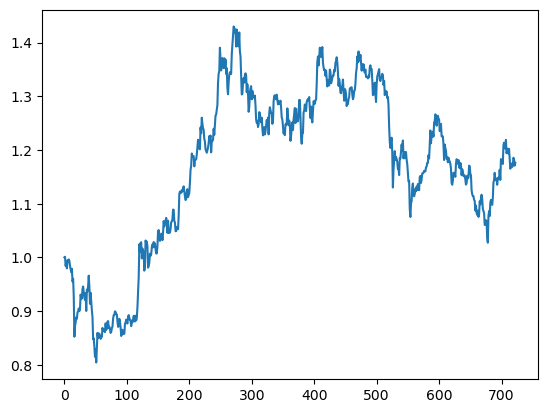

In [18]:
import seaborn as sns
sns.lineplot(env_trade.asset_memory)

In [19]:
env_trade.df

change      cr-ma3   log-ret  log_close/open  \
date       tic                                                         
2020-01-02 600010.SS  0.757575   80.858863  0.007547        0.000000   
           600030.SS  0.750993  115.418620  0.007482       -0.014081   
           600031.SS  5.278608  149.336482  0.051440        0.050712   
           600104.SS  1.341709   95.768860  0.013328        0.010183   
           600309.SS -0.498492  194.150484 -0.004997       -0.015661   
...                        ...         ...       ...             ...   
2022-12-30 600406.SS -3.059199  103.282641 -0.031070       -0.045970   
           600887.SS  0.421118  154.091491  0.004202        0.001397   
           601166.SS  0.860090  167.543019  0.008564        0.007401   
           601398.SS  0.930232  129.185995  0.009259        0.010007   
           601601.SS  2.723082  181.858926  0.026867        0.041180   

                      log_diff_high  log_diff_low  log_diff_open       ppo  \
date       tic                                                               
2020-01-02 600010.SS       0.010807      0.010971       0.010888  0.086040   
           600030.SS       0.009504      0.014927       0.008432  3.113831   
           600031.SS       0.049048      0.044811       0.042237  3.793472   
           600104.SS       0.031539      0.015126       0.013286  0.738554   
           600309.SS       0.010306      0.000259       0.012824  3.493883   
...                             ...           ...            ...       ...   
2022-12-30 600406.SS       0.001137     -0.032185       0.014968 -1.329975   
           600887.SS       0.012964      0.017910       0.012163  0.945006   
           601166.SS       0.003268      0.008320      -0.001648  0.807821   
           601398.SS       0.009984      0.013483       0.000000  0.361022   
           601601.SS       0.031838      0.021347      -0.016254  1.033114   

                          trix  
date       tic                  
2020-01-02 600010.SS  0.043303  
           600030.SS  0.428858  
           600031.SS  0.497622  
           600104.SS  0.128329  
           600309.SS  0.513200  
...                        ...  
2022-12-30 600406.SS -0.234339  
           600887.SS  0.204360  
           601166.SS  0.103446  
           601398.SS  0.041634  
           601601.SS  0.109395  

[7230 rows x 9 columns]

In [ ]:
# df_t = dfs_test[3]
# list_asset, actions = simulate_trading_masked(env_factory([df_t]), model)
# sr_asset = pd.Series(list_asset)
# sr_return = get_daily_return(sr_asset)
# backtest_stats(sr_return)
# sr_baseline_return = get_daily_return(df_t.close).dropna()
# sr_baseline_return = sr_baseline_return[len(sr_baseline_return) - len(sr_asset):]
# backtest_stats(sr_baseline_return)
# %matplotlib inline
# sr_date = df_t.date
# sr_date = sr_date[len(sr_date) - len(sr_asset):]
# sr_return.set_axis(sr_date, inplace=True)
# sr_baseline_return.set_axis(sr_date, inplace=True)
# backtest_plot(sr_return, sr_baseline_return)
# sum(actions)

# Plot